In [ ]:

import pandas as pd
import numpy as np
import sklearn as sk
import nltk

import matplotlib.pyplot as plt
import seaborn as sns


from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer





import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, AdamW
from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import Dropout
from torch.nn import Linear
from tqdm import tqdm
import torch.nn.functional as F


from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS as english_stopwords

import re
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Set random seed
np.random.seed(100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Descriptive Analysis

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Advanced_Data_Analytics_for_Business/FinalProject/sampled_english_songs_50000.csv')

In [ ]:
df.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Beautiful Tragedy,rock,Misery Loves Company,2017,264,{},I can't deal with all your constant regrets\nA...,3026810,en,en,en
1,Ice on my wrist,rap,Yung D (King),2018,936,{},Intro:\n(Ice on my wrist and it’s blinging)\nN...,3774739,en,en,en
2,Roof Back,rap,Say Kuro,2018,72,{},[Hook]\n\n\nI want the world thats gone be min...,4154965,en,en,en
3,Hit Tha Block,rb,CZARnicholas,2019,4,{},I can sense your spirit from a block away\nI j...,4768013,en,en,en
4,Home,pop,Jane Birkin,2006,127,{},Another round of interviews\nAnother pointless...,4783677,en,en,en


In [ ]:
second_lowest_year = df['year'].nunique()

# Get the unique years in the 'year' column
unique_years = df['year'].unique()

# Sort the unique years in ascending order
sorted_years = sorted(unique_years)

# The second lowest year is the element at index 1 (indexing starts from 0)
second_lowest_year = sorted_years[1]

print("The second lowest value in the 'year' column is:", second_lowest_year)


The second lowest value in the 'year' column is: 1961


In [ ]:
random_rows = df.sample(n=5)['lyrics']

# Display the entire text of the 'lyrics' column for the random rows
for lyrics_text in random_rows:
    print(lyrics_text)

Look into their eyes
What do you see?
I see fear, innocence and agony
Look at their souls
What do you see?
Punishment without criminality
Look into their minds
What do you see?
Why the fuck are you doing this to me?
Look at their flesh
What do you see?
The blood of needless pain from your insanity
Unseen
They suffer
Unheard
They cry
In agony
They linger
In loneliness
They die
Look at yourself
What do you see?
The bastard who inflicted pain on me
Look into your soul
What do you see?
The conscience of a killer who refuses to let me free
Look into your mind
What do you see?
Selfishness
The pedestal of apathy
Look into your heart
What do you see?
Surely not a human from your indecency
Electrodes in my head
Straps secure my arms
I know these humans
Are out to do me harm
Caged from day of birth
Unable to walk free
Why can't these bastards
Fucking let me be
I know these humans
Are out to do me harm
Endless, senseless torture on a science slaughter farm
Years of animal testing
How can this be 

In [ ]:
# Drop rows with missing values for specified variables
df.dropna(inplace=True)

In [ ]:
# Display the dimensions of the DataFrame
print(df.shape)

# Calculate the count of each value in the "Trainings-Labels" column
label_counts = df['tag'].value_counts()

# Print the label counts
print(label_counts)

(50000, 11)
pop        21824
rap        14771
rock        9757
rb          2400
country     1248
Name: tag, dtype: int64


## 1.1 Text Length and Word Count

Analyzing the distribution of text lengths and word count in the Lyrics column

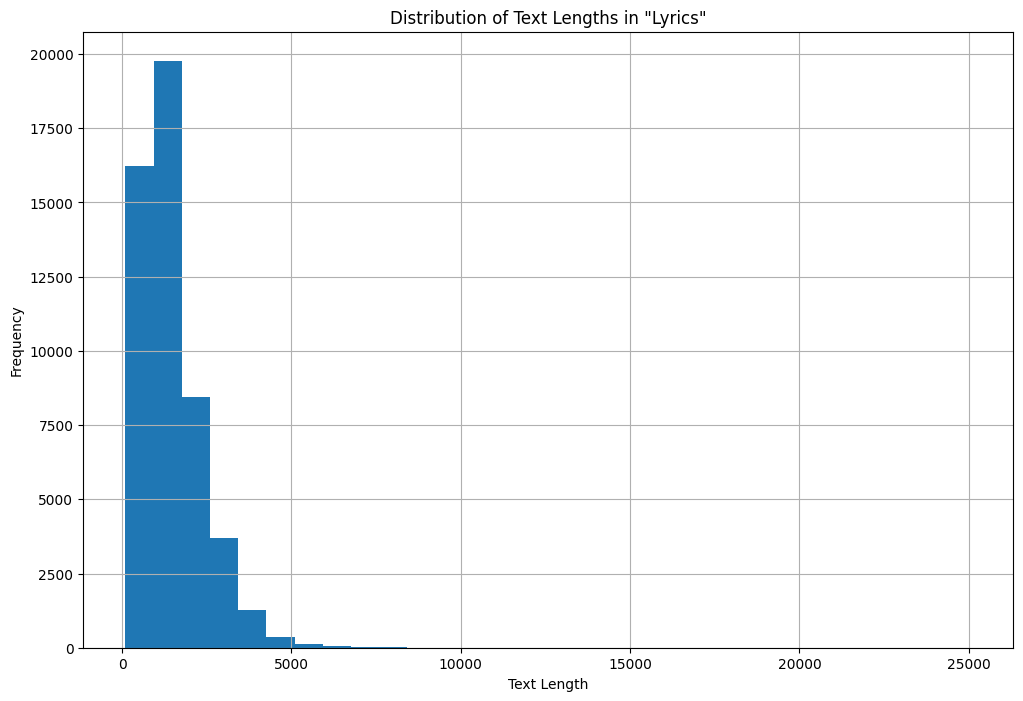

In [ ]:
# Calculate the length of texts in the lyrics column
df['lyrics_length'] = df['lyrics'].str.len()

# Visualize the distribution of text lengths using a histogram
df['lyrics_length'].hist(bins=30, figsize=(12, 8))
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in "Lyrics"')
plt.show()

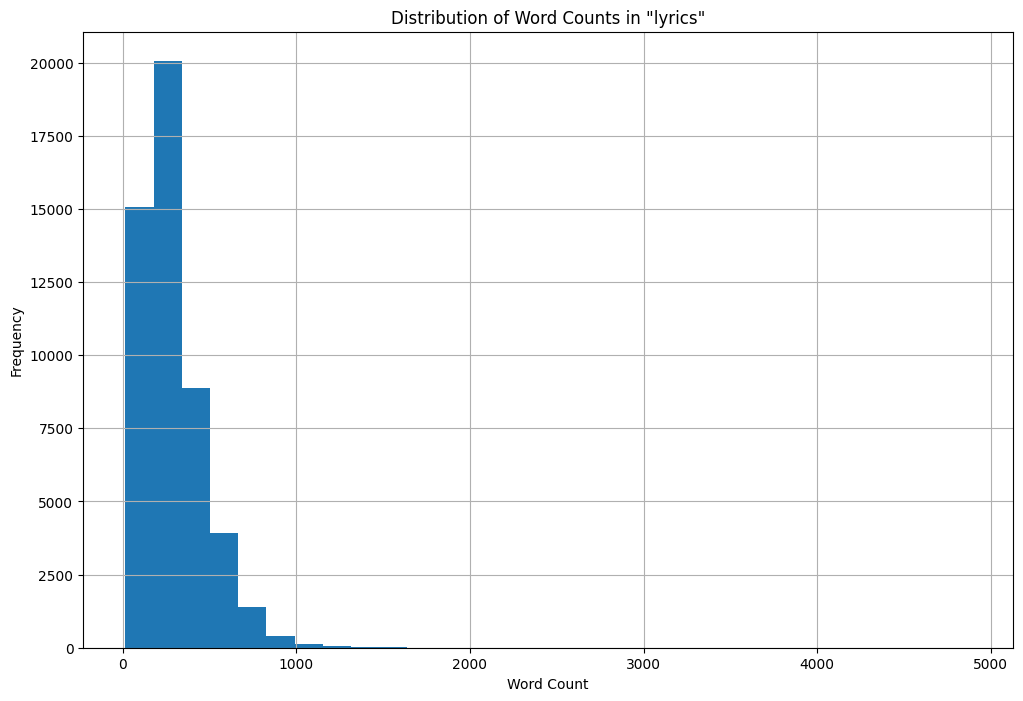

In [ ]:
# Calculate the number of words in the lyrics column
df['lyrics_word_count'] = df['lyrics'].str.split().str.len()
# Visualize the distribution of word counts using a histogram
df['lyrics_word_count'].hist(bins=30, figsize=(12, 8))
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in "lyrics"')
plt.show()

Now analyzing the distribution of text lengths and word count in different genres (pop, rap, rock, rb, country) and compare

Average text length for pop: 1159.45
Average word count for pop: 230.21
Average text length for rap: 2198.91
Average word count for rap: 435.04
Average text length for rock: 1044.05
Average word count for rock: 203.33
Average text length for rb: 1521.33
Average word count for rb: 306.33
Average text length for country: 1158.48
Average word count for country: 229.88


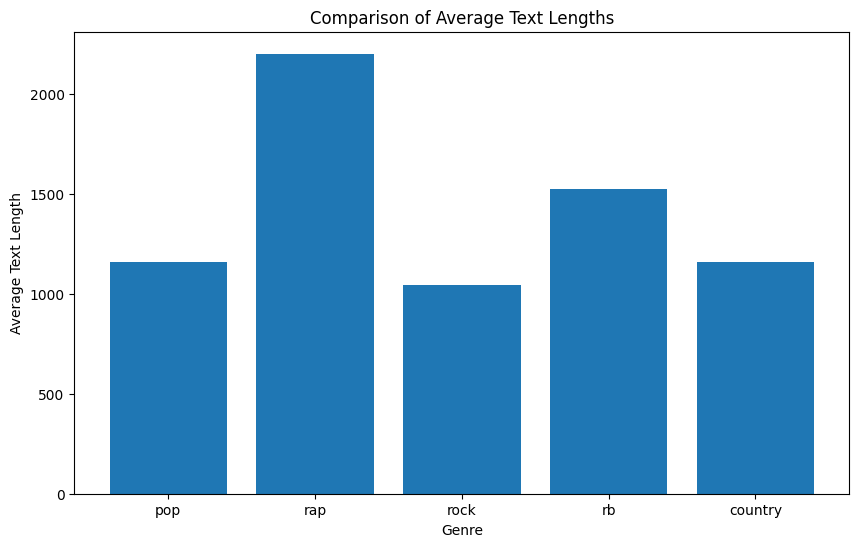

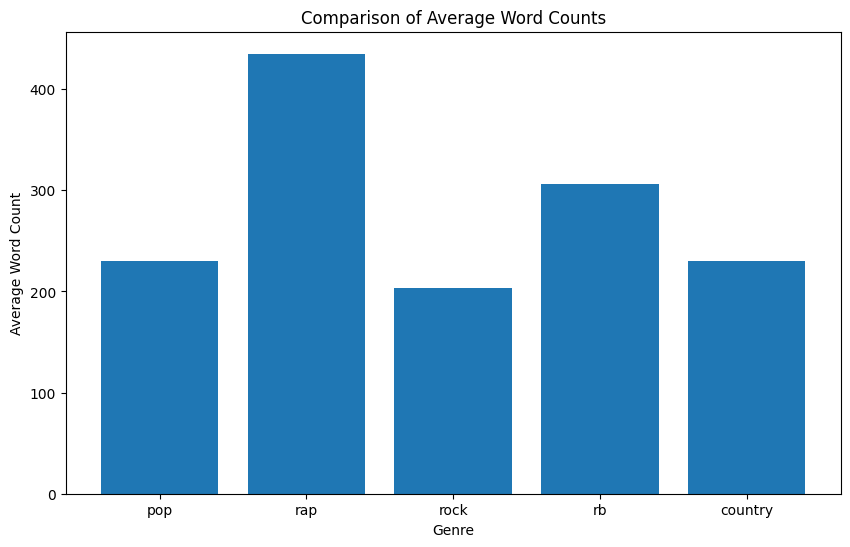

In [ ]:
target_values = ['pop', 'rap', 'rock', 'rb', 'country']

avg_text_length = []
avg_word_count = []

for target_value in target_values:
    # Calculate the length of texts in the lyrics column based on Genre
    lyrics_length = df.loc[df['tag'] == target_value, 'lyrics'].str.len()

    # Calculate the average text length
    avg_length = lyrics_length.mean()
    avg_text_length.append(avg_length)
    print(f"Average text length for {target_value}: {avg_length:.2f}")

    # Calculate the number of words in the lyrics column based on Genre
    lyrics_word_count = df.loc[df['tag'] == target_value, 'lyrics'].str.split().str.len()

    # Calculate the average word count
    avg_count = lyrics_word_count.mean()
    avg_word_count.append(avg_count)
    print(f"Average word count for {target_value}: {avg_count:.2f}")

# Plotting the comparison
x = np.arange(len(target_values))

# Plot average text length
plt.figure(figsize=(10, 6))
plt.bar(x, avg_text_length)
plt.xticks(x, target_values)
plt.xlabel('Genre')
plt.ylabel('Average Text Length')
plt.title('Comparison of Average Text Lengths')
plt.show()

# Plot average word count
plt.figure(figsize=(10, 6))
plt.bar(x, avg_word_count)
plt.xticks(x, target_values)
plt.xlabel('Genre')
plt.ylabel('Average Word Count')
plt.title('Comparison of Average Word Counts')
plt.show()

## 1.2 Word Frequency in Lyrics

Compare word frequency across different genres to figure out relationships in the genres

In [ ]:
# Separate the dataset into subsets based on case outcomes
pop_genre = df[df['tag'] == 'pop']
rap_genre = df[df['tag'] == 'rap']
rock_genre = df[df['tag'] == 'rock']
rb_genre = df[df['tag'] == 'rb']
country_genre = df[df['tag'] == 'country']


# Initialize CountVectorizer with English stopwords
english_stopwords = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=english_stopwords)

# Fit and transform the 'lyrics' text for the entire dataset
word_counts = vectorizer.fit_transform(df['lyrics'])

# Transform the 'lyrics' text for each genre
word_counts_pop = vectorizer.transform(pop_genre['lyrics'])
word_counts_rap = vectorizer.transform(rap_genre['lyrics'])
word_counts_rock = vectorizer.transform(rock_genre['lyrics'])
word_counts_rb = vectorizer.transform(rb_genre['lyrics'])
word_counts_country = vectorizer.transform(country_genre['lyrics'])

# Get the feature names (i.e., words) from the vectorizer vocabulary
feature_names = vectorizer.get_feature_names_out()

# Calculate the total word counts for each genre
total_word_counts_pop = word_counts_pop.sum(axis=0).tolist()[0]
total_word_counts_rap = word_counts_rap.sum(axis=0).tolist()[0]
total_word_counts_rock = word_counts_rock.sum(axis=0).tolist()[0]
total_word_counts_rb = word_counts_rb.sum(axis=0).tolist()[0]
total_word_counts_country = word_counts_country.sum(axis=0).tolist()[0]

# Create dictionaries to store the word frequencies for each genre
word_frequencies_pop = dict(zip(feature_names, total_word_counts_pop))
word_frequencies_rap = dict(zip(feature_names, total_word_counts_rap))
word_frequencies_rock = dict(zip(feature_names, total_word_counts_rock))
word_frequencies_rb = dict(zip(feature_names, total_word_counts_rb))
word_frequencies_country = dict(zip(feature_names, total_word_counts_country))

# Sort the word frequencies for each genre in descending order
sorted_word_frequencies_pop = sorted(word_frequencies_pop.items(), key=lambda x: x[1], reverse=True)
sorted_word_frequencies_rap = sorted(word_frequencies_rap.items(), key=lambda x: x[1], reverse=True)
sorted_word_frequencies_rock = sorted(word_frequencies_rock.items(), key=lambda x: x[1], reverse=True)
sorted_word_frequencies_rb = sorted(word_frequencies_rb.items(), key=lambda x: x[1], reverse=True)
sorted_word_frequencies_country = sorted(word_frequencies_country.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most frequent words for each case outcome
print("Top 10 most frequent words for pop:")
for word, count in sorted_word_frequencies_pop[:10]:
    print(word, ":", count)

print("\nTop 10 most frequent words for rap:")
for word, count in sorted_word_frequencies_rap[:10]:
    print(word, ":", count)

print("\nTop 10 most frequent words for rock:")
for word, count in sorted_word_frequencies_rock[:10]:
    print(word, ":", count)

print("\nTop 10 most frequent words for rb:")
for word, count in sorted_word_frequencies_rb[:10]:
    print(word, ":", count)

print("\nTop 10 most frequent words for country:")
for word, count in sorted_word_frequencies_country[:10]:
    print(word, ":", count)

Top 10 most frequent words for pop:
love : 32480
know : 31568
oh : 29471
like : 27911
chorus : 22009
go : 18616
time : 17548
yeah : 17353
got : 17333
one : 16899

Top 10 most frequent words for rap:
like : 62227
got : 40758
yeah : 36707
know : 36108
get : 35115
shit : 24161
verse : 23435
bitch : 22077
fuck : 21169
nigga : 19863

Top 10 most frequent words for rock:
chorus : 10417
know : 9957
verse : 8652
like : 8553
oh : 8292
love : 7243
time : 7129
never : 6867
one : 6799
see : 6400

Top 10 most frequent words for rb:
love : 6610
know : 6488
yeah : 5809
baby : 4853
oh : 4828
like : 4810
chorus : 4122
got : 4023
get : 3581
verse : 3396

Top 10 most frequent words for country:
chorus : 1754
verse : 1655
love : 1623
like : 1504
know : 1433
oh : 1285
got : 1176
time : 1080
one : 1038
go : 1005


## 1.3 Text Visualization

Using Word Clouds to visualize the distribution of word frequency in 'lyrics' column and to detect possible patterns and themes.

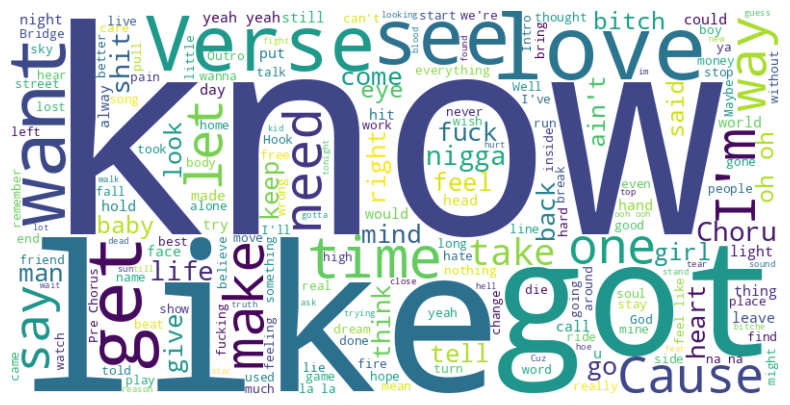

In [ ]:
# Combine all the texts from the 'lyrics' column
all_texts = ' '.join(df['lyrics'])

# Create a word cloud object with English stopwords excluded
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=english_stopwords).generate(all_texts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Save the word cloud to a file
#wordcloud.to_file("wordcloud.png")

## 1.4 Sentiment Analysis

### Provide Insights

into the emotional tone of the lyrics and potentially identify patterns related to different genres

In [ ]:
# Instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores for a given text
def calculate_sentiment_scores(text):
    if isinstance(text, float):
        return {'pos': 0, 'neg': 0, 'neu': 0}
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores

# Apply sentiment analysis to the text data
df['sentiment_scores'] = df['lyrics'].apply(calculate_sentiment_scores)

# Extract sentiment features
df['positive_sentiment'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['negative_sentiment'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['neutral_sentiment'] = df['sentiment_scores'].apply(lambda x: x['neu'])

# Print the first 5 rows of the updated dataframe with sentiment features
print(df.head(5))

               title   tag                artist  year  views features  \
0  Beautiful Tragedy  rock  Misery Loves Company  2017    264       {}   
1    Ice on my wrist   rap         Yung D (King)  2018    936       {}   
2          Roof Back   rap              Say Kuro  2018     72       {}   
3      Hit Tha Block    rb          CZARnicholas  2019      4       {}   
4               Home   pop           Jane Birkin  2006    127       {}   

                                              lyrics       id language_cld3  \
0  I can't deal with all your constant regrets\nA...  3026810            en   
1  Intro:\n(Ice on my wrist and it’s blinging)\nN...  3774739            en   
2  [Hook]\n\n\nI want the world thats gone be min...  4154965            en   
3  I can sense your spirit from a block away\nI j...  4768013            en   
4  Another round of interviews\nAnother pointless...  4783677            en   

  language_ft language  lyrics_length  lyrics_word_count  \
0          en       

In [ ]:
# Perform sentiment analysis on the 'lyrics' column
lambda x: TextBlob(str(x)).sentiment.polarity
df['Sentiment'] = df['lyrics'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

print(df.head())

               title   tag                artist  year  views features  \
0  Beautiful Tragedy  rock  Misery Loves Company  2017    264       {}   
1    Ice on my wrist   rap         Yung D (King)  2018    936       {}   
2          Roof Back   rap              Say Kuro  2018     72       {}   
3      Hit Tha Block    rb          CZARnicholas  2019      4       {}   
4               Home   pop           Jane Birkin  2006    127       {}   

                                              lyrics       id language_cld3  \
0  I can't deal with all your constant regrets\nA...  3026810            en   
1  Intro:\n(Ice on my wrist and it’s blinging)\nN...  3774739            en   
2  [Hook]\n\n\nI want the world thats gone be min...  4154965            en   
3  I can sense your spirit from a block away\nI j...  4768013            en   
4  Another round of interviews\nAnother pointless...  4783677            en   

  language_ft language  lyrics_length  lyrics_word_count  \
0          en       

In [ ]:
# Print the extracted sentiment features
print("Positive Sentiment:")
print(df['positive_sentiment'].head())

print("\nNegative Sentiment:")
print(df['negative_sentiment'].head())

print("\nNeutral Sentiment:")
print(df['neutral_sentiment'].head())

print(df['sentiment_scores'].head())

Positive Sentiment:
0    0.117
1    0.098
2    0.085
3    0.166
4    0.081
Name: positive_sentiment, dtype: float64

Negative Sentiment:
0    0.130
1    0.262
2    0.269
3    0.205
4    0.103
Name: negative_sentiment, dtype: float64

Neutral Sentiment:
0    0.753
1    0.640
2    0.646
3    0.629
4    0.816
Name: neutral_sentiment, dtype: float64
0    {'neg': 0.13, 'neu': 0.753, 'pos': 0.117, 'com...
1    {'neg': 0.262, 'neu': 0.64, 'pos': 0.098, 'com...
2    {'neg': 0.269, 'neu': 0.646, 'pos': 0.085, 'co...
3    {'neg': 0.205, 'neu': 0.629, 'pos': 0.166, 'co...
4    {'neg': 0.103, 'neu': 0.816, 'pos': 0.081, 'co...
Name: sentiment_scores, dtype: object


### Distribution of Sentiment Scores

Plot histograms and boxplots to visualize the distribution of sentiment scores for each genre. This can help identify any differences or patterns in sentiment between the genres.

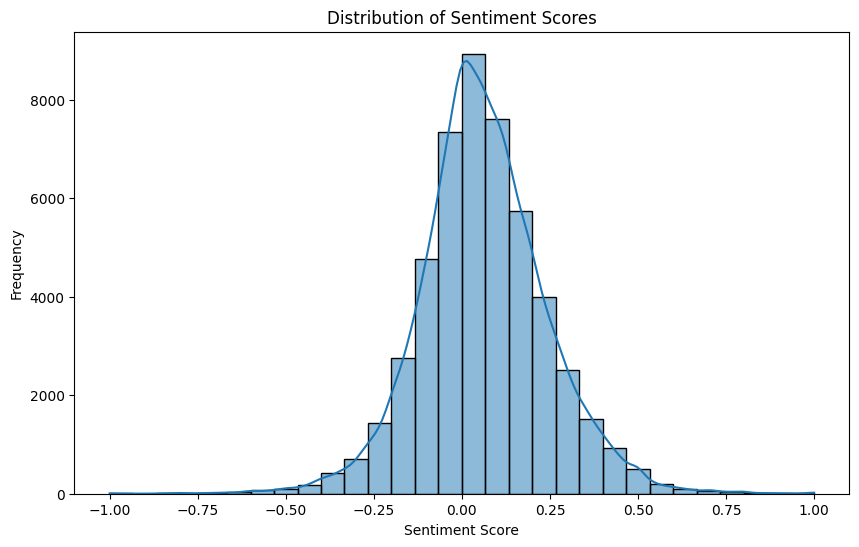

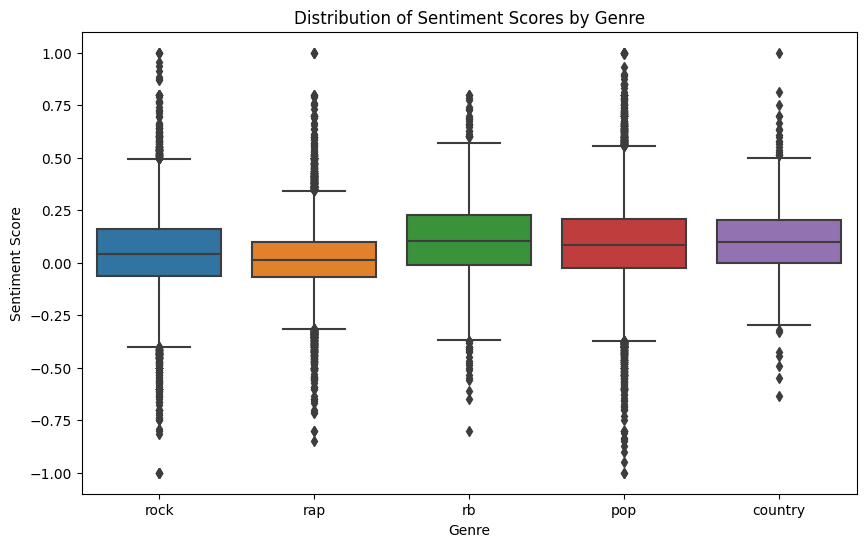

In [ ]:
# Plot histograms of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Sentiment', bins=30, kde=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

# Plot boxplots of sentiment scores for each genre
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='tag', y='Sentiment')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.title('Distribution of Sentiment Scores by Genre')
plt.show()

### Sentiment Comparison

Compare the average sentiment scores across different genres. We use bar plots to compare the average positive, negative, and neutral sentiment for all different genres.

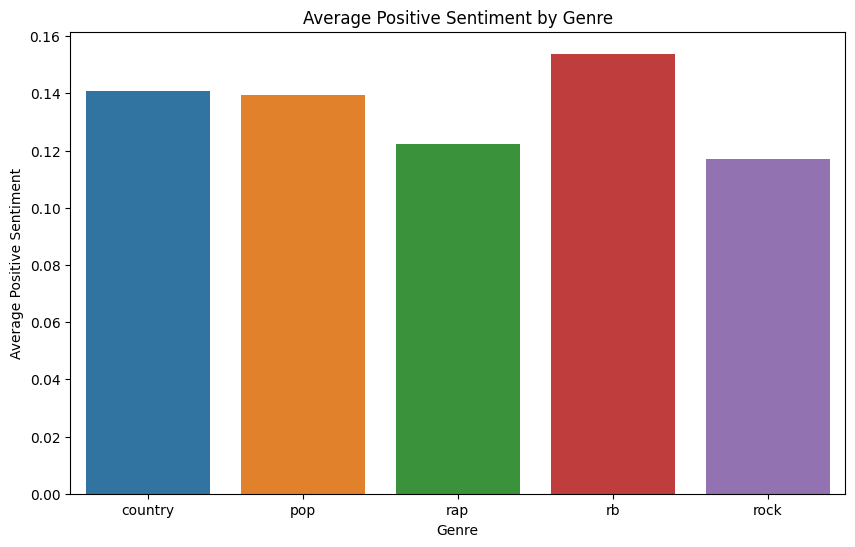

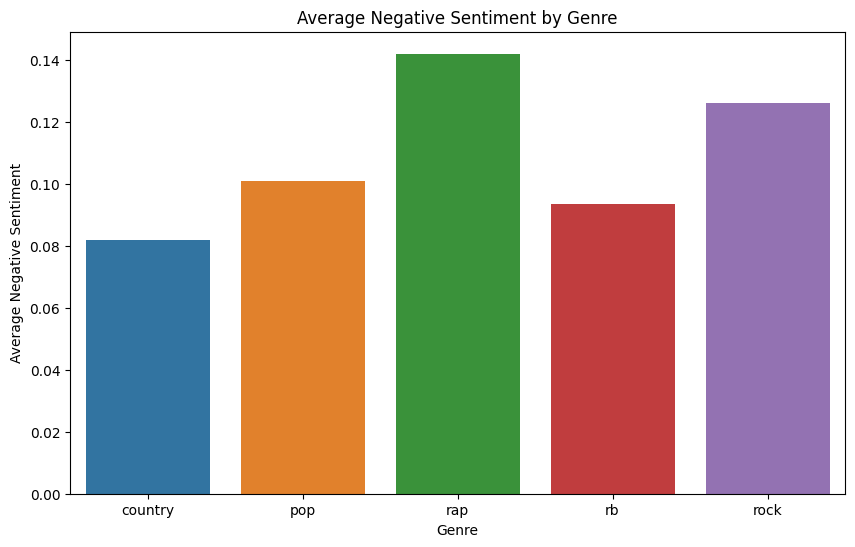

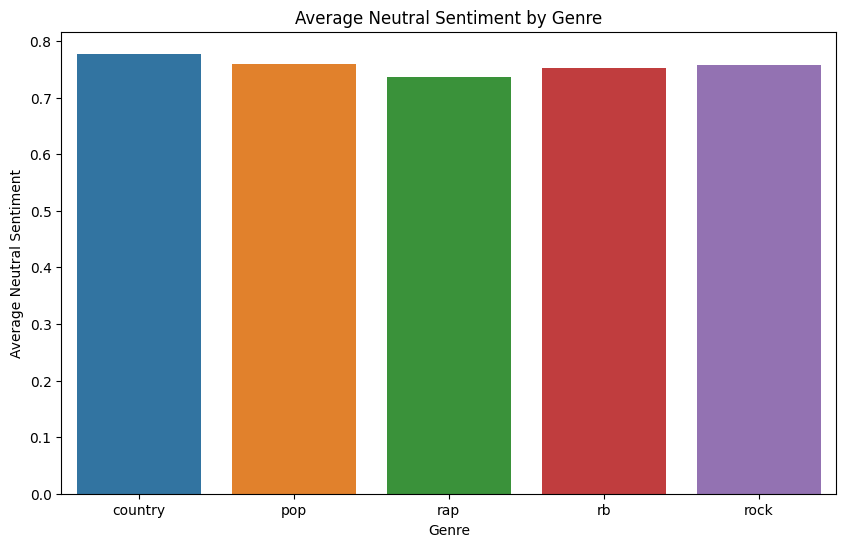

Average Positive Sentiment:
tag
country    0.140736
pop        0.139540
rap        0.122323
rb         0.153871
rock       0.116962
Name: positive_sentiment, dtype: float64

Average Negative Sentiment:
tag
country    0.081785
pop        0.100699
rap        0.141892
rb         0.093445
rock       0.126052
Name: negative_sentiment, dtype: float64

Average Neutral Sentiment:
tag
country    0.777464
pop        0.759760
rap        0.735787
rb         0.752670
rock       0.756980
Name: neutral_sentiment, dtype: float64


In [ ]:
# Calculate the average sentiment scores for each case genre
avg_positive_sentiment = df.groupby('tag')['positive_sentiment'].mean()
avg_negative_sentiment = df.groupby('tag')['negative_sentiment'].mean()
avg_neutral_sentiment = df.groupby('tag')['neutral_sentiment'].mean()

# Create a bar plot to compare the average positive sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_positive_sentiment.index, y=avg_positive_sentiment)
plt.xlabel('Genre')
plt.ylabel('Average Positive Sentiment')
plt.title('Average Positive Sentiment by Genre')
plt.show()

# Create a bar plot to compare the average negative sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_negative_sentiment.index, y=avg_negative_sentiment)
plt.xlabel('Genre')
plt.ylabel('Average Negative Sentiment')
plt.title('Average Negative Sentiment by Genre')
plt.show()

# Create a bar plot to compare the average neutral sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_neutral_sentiment.index, y=avg_neutral_sentiment)
plt.xlabel('Genre')
plt.ylabel('Average Neutral Sentiment')
plt.title('Average Neutral Sentiment by Genre')
plt.show()

print("Average Positive Sentiment:")
print(avg_positive_sentiment)

print("\nAverage Negative Sentiment:")
print(avg_negative_sentiment)

print("\nAverage Neutral Sentiment:")
print(avg_neutral_sentiment)

### Sentiment Trends

Analyze the sentiment scores over time. Explore how sentiment evolves across different time periods and its relationship with different genres.

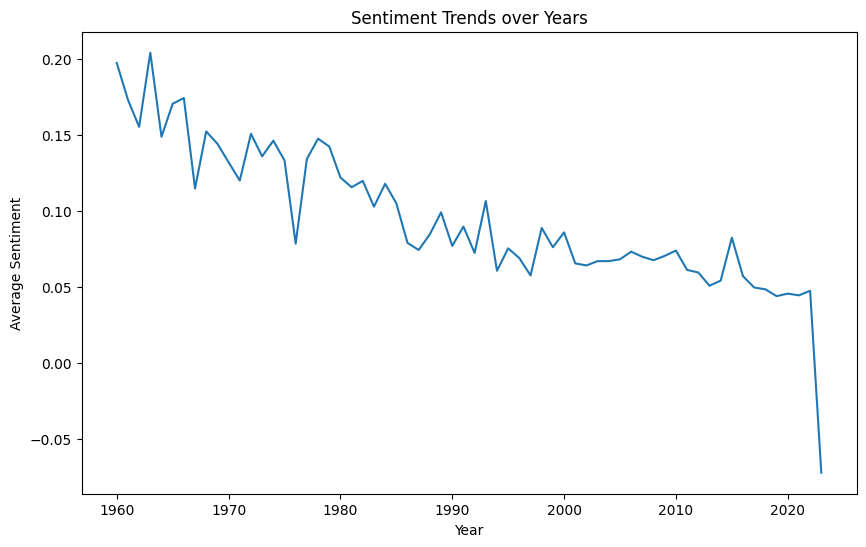

Average Sentiment Scores by Year:
year
1960    0.197138
1961    0.172974
1962    0.155129
1963    0.203909
1964    0.148647
1965    0.170297
1966    0.174109
1967    0.114574
1968    0.152116
1969    0.144010
1970    0.131816
1971    0.119790
1972    0.150544
1973    0.135705
1974    0.146028
1975    0.133033
1976    0.078285
1977    0.133974
1978    0.147332
1979    0.142209
1980    0.121812
1981    0.115390
1982    0.119563
1983    0.102605
1984    0.117651
1985    0.104793
1986    0.078716
1987    0.074098
1988    0.084479
1989    0.098871
1990    0.076797
1991    0.089506
1992    0.072157
1993    0.106340
1994    0.060403
1995    0.075176
1996    0.068724
1997    0.057349
1998    0.088585
1999    0.075909
2000    0.085685
2001    0.065263
2002    0.063928
2003    0.066742
2004    0.066762
2005    0.067970
2006    0.072985
2007    0.069621
2008    0.067366
2009    0.070212
2010    0.073703
2011    0.060976
2012    0.059293
2013    0.050569
2014    0.053890
2015    0.082170
2016    0

In [ ]:
# Calculate the average sentiment scores for each year
avg_sentiment_by_year = df.groupby('year')['Sentiment'].mean()

# Plot the sentiment trends over years
plt.figure(figsize=(10, 6))
plt.plot(avg_sentiment_by_year.index, avg_sentiment_by_year.values)
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.title('Sentiment Trends over Years')
plt.show()

# Print the average sentiment scores
print("Average Sentiment Scores by Year:")
print(avg_sentiment_by_year.to_string(index=True))